In [127]:
%reset -sf

In [128]:
import torch
from torch.utils.checkpoint import checkpoint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from opt_einsum import contract
from torch.profiler import profile, record_function, ProfilerActivity
def _toN(t):
    return t.detach().cpu().numpy()
def printDiff(name,value,ref):
    if ref is not None:
        print(name+':',value,'diff(abs):',value-ref)
    else:
        print(name+':',value)
import os
if '__file__' in globals():
    script_name=os.path.splitext(os.path.basename(__file__))[0]
else:
    script_name='notebook'
    
import ast
def eval_np_array_literal(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))


# SRG BaseClass

In [129]:
class SRG(torch.nn.Module):
    def __init__(self,params,options):
        super(SRG,self).__init__()
        self.dtype=options.get('dtype',torch.float64)
        self.device=options.get('device','cpu')
        self.max_dim=options.get('max_dim',16)
        self.nLayers=options.get('nLayers',10)
        self.use_checkpoint=options.get('use_checkpoint',True)
        self.observable_checkerboard=False
        
        self.params=torch.nn.ParameterDict({
            k:torch.nn.Parameter(torch.tensor(v,dtype=self.dtype,device=self.device)) for k,v in params.items()
        })
        self.logZ=0
        
    def __str__(self):
        rtval=""
        for k,v in self.params.items():
            rtval+=k+':'+v+'\n'
        rtval+='dtype:'+self.dtype+'\n'
        rtval+='device:'+self.device+'\n'
        rtval+='max_dim:'+self.max_dim+'\n'
        rtval+='nLayers:'+self.nLayers+'\n'
        rtval+='nSite:'+2**nLayers+'\n'
        
    def set_params(self,params):
        self.params=torch.nn.ParameterDict({
            k:torch.nn.Parameter(torch.tensor(v,dtype=self.dtype,device=self.device)) for k,v in params.items()
        })
        
    def toT(self,t):
        return torch.tensor(t,dtype=self.dtype,device=self.device)
    
    def generate_random_Isometry(self,dim1,dim2):
        dim=max(dim1,dim2)
        A=torch.randn(dim,dim,dtype=self.dtype,device=self.device)
        U=torch.matrix_exp(A-A.t())
        U=U[:dim1,:dim2]
        return U
    
    def TRG_same_T(self,T,*w):
        return self.TRG(T,T,*w)
    
    def forward_tensor(self):
        logTotal=0
        T=self.get_T0()
        for i in range(self.nLayers):
            w=self.ws[(i*self.w_per_layer):((i+1)*self.w_per_layer)]
            if self.use_checkpoint:
                T=torch.utils.checkpoint.checkpoint(self.TRG_same_T,T,*w)
            else:
                T=self.TRG_same_T(T,*w)
                
            norm=torch.linalg.norm(T)
            T=T/norm
            logTotal=2*logTotal+torch.log(norm)
        return T,logTotal
    
    def forward_tensor_with_observable(self,T_op):
        logTotal=0
        T=self.get_T0()
        for i in range(self.nLayers):
            w=self.ws[(i*self.w_per_layer):((i+1)*self.w_per_layer)]
            if self.use_checkpoint:
                T1=torch.utils.checkpoint.checkpoint(self.TRG_same_T,T,*w)
                T2=torch.utils.checkpoint.checkpoint(self.TRG,T,T_op,*w)
                T3=torch.utils.checkpoint.checkpoint(self.TRG,T_op,T,*w)
            else:
                T1=self.TRG_same_T(T,*w)
                T2=self.TRG(T,T_op,*w)
                T3=self.TRG(T_op,T,*w)
            if self.observable_checkerboard and i<self.spacial_dim:
                T3=-T3

            T,T_op=T1,(T2+T3)/2
            norm=torch.linalg.norm(T)
            T,T_op=T/norm,T_op/norm
            logTotal=2*logTotal+torch.log(norm)
        return T,T_op,logTotal
    
    
    def dlogZ(self,param):
        self.requires_grad_(False)
        self.params[param].requires_grad_(True)
        self.zero_grad()
        logZ=self.forward()
        logZ.backward()
        result=_toN(self.params[param].grad)
        self.params[param].requires_grad_(False)
        return result
    
    def update_single_layer(self,layer):
        self.requires_grad_(False)
        
        for i in range(layer*self.w_per_layer,(layer+1)*self.w_per_layer):
            self.ws[i].requires_grad_(True)
        self.zero_grad()
        
        logZ=self.forward()
        logZ.backward()
        
        with torch.no_grad():
            for i in range(layer*self.w_per_layer,(layer+1)*self.w_per_layer):
                E=self.ws[i].grad
                dim1,dim2=E.shape[0],E.shape[2]
                E=E.reshape(dim1*dim1,dim2)
                U,S,Vh=torch.linalg.svd(E,full_matrices=False)
                UVh=U@Vh
                #UVh=svd2UVh(E)
                del U,S,Vh,E
                
                #calculate diff
                UVh_old=self.ws[i].reshape(dim1*dim1,dim2)
                self.ws_diff[i]=_toN(torch.norm(UVh_old.t()@UVh@UVh.t()@UVh_old-torch.eye(dim2,device=UVh.device)))
                del UVh_old
                    
                self.ws[i].data=UVh.reshape(dim1,dim1,dim2)
                del UVh
                torch.cuda.empty_cache()
        return _toN(logZ)
        
    def optimize(self,nIter):
        self.ws_diff=np.zeros(len(self.ws))
        
        torch.cuda.empty_cache()
        if nIter>1:
            pbar2=tqdm(range(nIter), leave=False)
            pbar2.set_postfix({k:_toN(v) for k,v in self.params.items()})
        else:
            pbar2=range(nIter)
        for i in pbar2:
            pbar=tqdm([*range(self.nLayers-1,-1,-1)]+[*range(self.nLayers)], leave=False)
            for j in pbar:
                new_logZ=self.update_single_layer(j)
        #lock all grads
        for param in self.params.values(): 
            param.requires_grad_(False)
        for i in range(self.nLayers): #slightly faster
            self.ws[i].requires_grad_(False)
        
        self.logZ_diff=np.abs(self.logZ-new_logZ)
        self.logZ=new_logZ
        # normalized by layer weight, number of elements in tensor
        # but multiply by number of elements in last tensor to better match the effects in output
        self.ws_diff_normalized=np.zeros(len(self.ws))
        for i in range(self.nLayers):
            for j in range(self.w_per_layer):
                ij=i*self.w_per_layer+j
                self.ws_diff_normalized[ij]=self.ws_diff[ij]/2**i/torch.numel(self.ws[ij])*torch.numel(self.ws[-1])
        # ignore the last layers we take trace directly
        # use 10-norm so layers of large error has beter contribution       
        self.ws_diff_total=np.average(self.ws_diff_normalized[:-self.w_per_layer*self.spacial_dim]**10)**.1


In [130]:
class HOTRG(SRG):
    def __init__(self,params,options):
        super(HOTRG,self).__init__(params,options)
    
    def create_isometries(self,start_dim,spacial_dim):
        ws=[]
        bond_dim=[start_dim]*spacial_dim
        for i in range(self.nLayers):
            for j in range(1,spacial_dim):
                old_dim=bond_dim[j]
                new_dim=min(old_dim**2,self.max_dim)
                U=self.generate_random_Isometry(old_dim**2,new_dim).view(old_dim,old_dim,new_dim)
                ws.append(U.detach())
                bond_dim[j]=new_dim
            bond_dim=bond_dim[1:]+[bond_dim[0]]
        self.ws=torch.nn.ParameterList([
            torch.nn.Parameter(v) for v in ws
        ])
        self.w_per_layer=spacial_dim-1
        self.spacial_dim=spacial_dim
        
    def HOTRG2D(self,T1,T2,w):
        return contract('ijkl,jmno,kna,lob->abim',T1,T2,w,w)#contract and rotate
    
    def HOTRG3D(self,T1,T2,w1,w2):
        return contract('ijklmn,jopqrs,kpa,lqb,mrc,nsd->abcdio',T1,T2,w1,w1,w2,w2)#contract and rotate
    
    def forward(self):
        T,logTotal=self.forward_tensor()
        contract_all=[i for i in range(len(T.shape)//2) for j in range(2)]
        Z=contract(T,contract_all)
        return (torch.log(Z)+logTotal)/2**self.nLayers
    
    def forward_with_observable(self,T_op):
        T,T_op,_=self.forward_tensor_with_observable(T_op)
        contract_all=[i for i in range(len(T.shape)//2) for j in range(2)]
        Z=contract(T,contract_all)
        Z_op=contract(T_op,contract_all)
        return Z_op/Z


# AKLT Public

In [131]:
from scipy.special import comb
def get_CG_no_normalization(n):
    if n==0:
        return np.eye(1)
    CG=np.zeros((n+1,)+(2,)*n)
    for i in range(2**n):
        indices=tuple(map(int,bin(i)[2:].zfill(n)))
        m=np.sum(indices)
        CG[(m,)+indices]=1
    return CG
def get_CG(n):
    if n==0:
        return np.eye(1)
    CG=np.zeros((n+1,)+(2,)*n)
    for i in range(2**n):
        indices=tuple(map(int,bin(i)[2:].zfill(n)))
        m=np.sum(indices)
        CG[(m,)+indices]=1/np.sqrt(comb(n,m))
    return CG
def get_Singlet():
    return np.array([[0,1.],[-1.,0]])

#print(get_CG_no_normalization(4).reshape(5,-1))
#print(get_CG(3).reshape(4,-1))
assert get_CG(3).shape==(4,2,2,2)
assert np.isclose(get_CG(3).reshape(4,-1)@get_CG(3).reshape(4,-1).T,torch.eye(4)).all()
#print(get_Singlet())
assert np.isclose(get_Singlet()@get_Singlet(),-torch.eye(2)).all()
assert (get_Singlet()==-get_Singlet().T).all()


# AKLT 2D

In [132]:
class AKLT2D(HOTRG):
    default_params={'a1':np.sqrt(6)/2,'a2':np.sqrt(6)}
    def __init__(self,params,options):
        super(AKLT2D,self).__init__(params,options)
        self.create_isometries(start_dim=4,spacial_dim=2)
        self.TRG=self.HOTRG2D
        self.observable_checkerboard=True
        self.magnetization=0
        self.magnetization_diff=0
        
        
    def get_T0(self):
        projector=self.toT(get_CG_no_normalization(4))
        singlet=self.toT([[0,-1],[1,0]])
        ac0,ac1,ac2=self.toT(1),self.params['a1'],self.params['a2']
        deform=torch.stack([ac2,ac1,ac0,ac1,ac2])
        node=contract('aijkl,im,kn,a->amjnl',projector,singlet,singlet,deform)
        return contract('aijkl,amnop->imjnkolp',node,node).reshape(4,4,4,4)#UDLR

    def get_SZT0(self):
        projector=self.toT(get_CG_no_normalization(4))
        singlet=self.toT([[0,-1],[1,0]])
        ac0,ac1,ac2=self.toT(1),self.params['a1'],self.params['a2']
        deform=torch.stack([ac2,ac1,ac0,ac1,ac2])
        node=contract('aijkl,im,kn,a->amjnl',projector,singlet,singlet,deform)
        op=self.toT([2,1,0,-1,-2])
        return contract('aijkl,amnop,a->imjnkolp',node,node,op).reshape(4,4,4,4)#UDLR
    
    def calc_magnetization(self):
        with torch.no_grad():
            new_magnetization=_toN(torch.abs(self.forward_with_observable(self.get_SZT0())))
            self.magnetization_diff=np.abs(self.magnetization-new_magnetization)
            self.magnetization=new_magnetization


# Determine convergence

In [ ]:
options={
    'dtype':torch.float64,
    'device':'cuda:0',
    'max_dim':15, # 50 for float32
    'nLayers':20,
    'use_checkpoint':True
}
print(options)

MAX_ITER=200
EARLY_TIME_ITER=10
LATE_TIME_ITER=100
THRESHOLD_AVERAGE_WINDOW=10
THRESHOLD=5e-8
THRESHOLD_LATE=5e-7
THRESHOLD_PHASE_TRANSITION=10

REUSE_W=True

a2s=np.linspace(1.77,1.79,21)

data=pd.DataFrame()
model=AKLT2D
srg=model(model.default_params,options)

for a2 in a2s:
    params={'a1':0,'a2':a2}
    if not REUSE_W:
        srg=model(params,options)
    srg.set_params(params)
    
    loss_curve=[]
    pbar=tqdm(range(MAX_ITER))
    
    for _iter in pbar:
        
        srg.optimize(1)
        srg.calc_magnetization()
        
        pbar.set_postfix({'ΔlogZ':srg.logZ_diff,'Δm':srg.magnetization_diff,'Δw':srg.ws_diff_total})
        
        newRow={**params,'iter':_iter+1,
                'logZ':srg.logZ,'magnetization':srg.magnetization,
                'logZ_diff':srg.logZ_diff,'magnetization_diff':srg.magnetization_diff,
                'ws_diff_total':srg.ws_diff_total,
                'ws_diff':srg.ws_diff,
                'ws_diff_normalized':srg.ws_diff_normalized,
               }
        data=data.append(newRow,ignore_index=True)
        data.to_csv(script_name+'.csv')
        
        loss_curve.append(srg.ws_diff_total)
        average_loss=np.average(np.array(loss_curve[-THRESHOLD_AVERAGE_WINDOW:])**10)**.1
        
        if REUSE_W and _iter==EARLY_TIME_ITER and np.max(loss_curve[3:])>THRESHOLD_PHASE_TRANSITION*np.min(loss_curve[:3]):
            print('phase transition detected!')
            print('randomize isometries')
            srg=model(params,options)
            continue
        if _iter>=EARLY_TIME_ITER and average_loss<THRESHOLD:
            print('converged!')
            break
        elif _iter>=LATE_TIME_ITER and average_loss<THRESHOLD_LATE:
            print('late converged!')
            break
        
    for k,v in newRow.items():
        print(k,':',v,end=' ')
    print()


{'dtype': torch.float64, 'device': 'cuda:0', 'max_dim': 15, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

converged!
a1 : 0 a2 : 1.77 iter : 99 logZ : 1.1671968041601188 magnetization : 3.049944911861587e-06 logZ_diff : 4.826573141158974e-09 magnetization_diff : 2.063698321856754e-06 ws_diff_total : 7.71578131326318e-09 ws_diff : [3.29810379e-14 6.02892831e-10 1.09217169e-13 2.26859280e-11
 1.11052949e-12 4.35437270e-12 1.74321703e-11 1.01004306e-09
 3.98489423e-10 5.27380443e-06 1.92950126e-08 2.48386484e-06
 2.06055539e-07 1.02067220e-06 4.94898265e-06 2.12402486e-05
 2.28065255e-04 6.80904408e-04 9.78349055e-01 2.37620836e+00] ws_diff_normalized : [4.63795846e-13 4.23909022e-09 2.73042922e-14 2.83574100e-12
 6.94080929e-14 1.36074147e-13 2.72377661e-13 7.89096141e-12
 1.55659931e-12 1.03003993e-08 1.88427858e-11 1.21282463e-09
 5.03065281e-11 1.24593774e-10 3.02061929e-10 6.48200946e-10
 3.47999962e-09 5.19488836e-09 3.73210547e-06 4.53225776e-06] 


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

converged!
a1 : 0 a2 : 1.771 iter : 17 logZ : 1.1678852270956472 magnetization : 9.230791439450964e-07 logZ_diff : 3.751974286814175e-09 magnetization_diff : 1.4877341264352844e-06 ws_diff_total : 3.342403789866187e-09 ws_diff : [2.58142382e-14 6.15219525e-11 2.78571335e-14 2.30129202e-12
 7.00579865e-13 2.68652540e-12 7.74253095e-11 1.54314319e-09
 3.18016187e-09 8.91295341e-07 4.21887684e-08 4.37923723e-07
 6.28414362e-07 4.35286006e-07 9.18533747e-06 8.17752626e-06
 2.92457239e-04 1.69133702e-04 6.66434953e-01 2.18054730e+00] ws_diff_normalized : [3.63012725e-13 4.32576229e-10 6.96428337e-15 2.87661503e-13
 4.37862416e-14 8.39539186e-14 1.20977046e-12 1.20558062e-11
 1.24225073e-11 1.74081121e-09 4.11999692e-11 2.13829943e-10
 1.53421475e-10 5.31354988e-11 5.60628508e-10 2.49558296e-10
 4.46254331e-09 1.29038774e-09 2.54224759e-06 4.15906392e-06] 


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

converged!
a1 : 0 a2 : 1.772 iter : 17 logZ : 1.16857767293428 magnetization : 1.4804687519774823e-06 logZ_diff : 4.897118266455891e-10 magnetization_diff : 7.611626527828165e-07 ws_diff_total : 4.7962030992993315e-09 ws_diff : [3.18628412e-14 9.46223346e-12 3.28039833e-14 4.04509052e-13
 5.35066499e-13 3.32235690e-12 4.66975935e-11 3.59612964e-10
 2.76929100e-09 9.38021253e-08 3.79751839e-08 1.14025916e-07
 4.36879548e-07 7.58364546e-07 6.89649672e-06 1.72725022e-05
 2.63573861e-04 8.38528879e-04 8.72232312e-01 2.37648178e+00] ws_diff_normalized : [4.48071205e-13 6.65313290e-11 8.20099583e-15 5.05636315e-14
 3.34416562e-14 1.03823653e-13 7.29649898e-13 2.80947628e-12
 1.08175430e-11 1.83207276e-10 3.70851405e-11 5.56767170e-11
 1.06660046e-10 9.25737971e-11 4.20928755e-10 5.27114936e-10
 4.02181795e-09 6.39746764e-09 3.32730222e-06 4.53277927e-06] 


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

converged!
a1 : 0 a2 : 1.7730000000000001 iter : 12 logZ : 1.169274304521391 magnetization : 2.134263341517294e-06 logZ_diff : 6.1901839210065646e-09 magnetization_diff : 8.561706481709471e-08 ws_diff_total : 4.2307553435564304e-08 ws_diff : [2.50204115e-14 9.76632412e-13 5.69363554e-14 2.24085384e-13
 1.61820407e-12 8.99984248e-12 1.76550143e-10 3.04562550e-10
 1.00401607e-08 1.87874880e-08 1.40008557e-07 2.25156473e-07
 6.81581486e-07 3.98702541e-06 2.84938696e-06 1.13544616e-04
 2.52541197e-04 7.40380699e-03 1.21386927e+00 1.78839636e+00] ws_diff_normalized : [3.51849537e-13 6.86694665e-12 1.42340888e-14 2.80106730e-14
 1.01137755e-13 2.81245077e-13 2.75859598e-12 2.37939492e-12
 3.92193779e-11 3.66943124e-11 1.36727107e-10 1.09939684e-10
 1.66401730e-10 4.86697437e-10 1.73912778e-10 3.46510670e-09
 3.85347286e-09 5.64865645e-08 4.63054377e-06 3.41109535e-06] 


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

converged!
a1 : 0 a2 : 1.774 iter : 12 logZ : 1.1699753868454668 magnetization : 4.1279621156172066e-07 logZ_diff : 1.1391332765953166e-08 magnetization_diff : 4.1966306884131015e-06 ws_diff_total : 9.592504317210265e-09 ws_diff : [2.82132962e-14 1.10770921e-13 1.91372236e-13 7.00849644e-13
 2.85071226e-12 1.30652393e-11 2.25239981e-10 9.43514744e-10
 1.27665888e-08 4.59911556e-08 2.83291213e-07 5.26609968e-07
 6.44341034e-07 4.50585753e-06 6.37096985e-06 5.68523774e-05
 3.89128610e-04 1.67860787e-03 1.42036080e+00 2.21822416e+00] ws_diff_normalized : [3.96749477e-13 7.78858040e-13 4.78430589e-14 8.76062055e-14
 1.78169516e-13 4.08288727e-13 3.51937470e-12 7.37120894e-12
 4.98694875e-11 8.98264758e-11 2.76651575e-10 2.57133773e-10
 1.57309823e-10 5.50031437e-10 3.88853140e-10 1.73499687e-09
 5.93763137e-09 1.28067617e-08 5.41824648e-06 4.23092682e-06] 


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

converged!
a1 : 0 a2 : 1.775 iter : 12 logZ : 1.1706811322493285 magnetization : 1.8358271788972292e-07 logZ_diff : 3.837344220158911e-09 magnetization_diff : 5.903734701510272e-07 ws_diff_total : 1.5732324820115887e-08 ws_diff : [3.07564866e-14 7.71945428e-12 3.48448308e-14 3.06788742e-13
 9.11053974e-13 3.87683483e-12 1.02133866e-10 2.07984078e-10
 1.88438517e-08 1.30100141e-08 7.31604308e-07 2.58551315e-07
 4.80553816e-07 1.16846023e-06 1.80652507e-06 2.88381598e-05
 1.33942213e-03 2.38636531e-03 1.11438191e+00 2.10075747e+00] ws_diff_normalized : [4.32513093e-13 5.42774129e-11 8.71120771e-15 3.83485927e-14
 5.69408734e-14 1.21151089e-13 1.59584166e-12 1.62487561e-12
 7.36087957e-11 2.54101838e-11 7.14457332e-10 1.26245759e-10
 1.17322709e-10 1.42634306e-10 1.10261540e-10 8.80070794e-10
 2.04379598e-08 1.82065224e-08 4.25102964e-06 4.00687689e-06] 


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

converged!
a1 : 0 a2 : 1.776 iter : 12 logZ : 1.1713918492134754 magnetization : 4.922055483246365e-06 logZ_diff : 6.281490438908577e-09 magnetization_diff : 4.186336388067501e-06 ws_diff_total : 1.248054458102693e-08 ws_diff : [3.30541369e-14 1.04619392e-10 4.92675790e-14 3.11049029e-12
 1.44415807e-12 6.38917470e-12 2.06303980e-10 1.23842791e-09
 1.04723443e-08 3.97924620e-08 4.91309715e-07 5.48753667e-07
 9.83115655e-07 9.40294409e-07 9.12873898e-06 4.39130482e-06
 8.43896515e-04 2.16690870e-03 8.76948130e-01 2.38934425e+00] ws_diff_normalized : [4.64823801e-13 7.35605101e-10 1.23168947e-14 3.88811286e-13
 9.02598794e-14 1.99661709e-13 3.22349968e-12 9.67521807e-12
 4.09075947e-11 7.77196523e-11 4.79794643e-10 2.67946126e-10
 2.40018470e-10 1.14782032e-10 5.57174010e-10 1.34011988e-10
 1.28768389e-08 1.65322014e-08 3.34529163e-06 4.55731248e-06] 


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

converged!
a1 : 0 a2 : 1.7770000000000001 iter : 12 logZ : 1.1721078754702545 magnetization : 1.8756399938230365e-06 logZ_diff : 7.636130838761801e-09 magnetization_diff : 8.08210592027974e-06 ws_diff_total : 1.3684377376342333e-08 ws_diff : [2.62490750e-14 2.59848203e-09 1.09345385e-13 7.17280598e-11
 1.54374533e-12 4.92620525e-12 1.99110683e-10 8.93245757e-10
 1.05744135e-08 3.16586126e-08 6.89091312e-07 9.04742717e-07
 9.46089144e-07 1.34627008e-06 5.50716939e-06 8.62142754e-06
 2.68697186e-04 5.61310732e-04 4.85098111e-01 1.90591514e+00] ws_diff_normalized : [3.69127617e-13 1.82705767e-08 2.73363463e-14 8.96600748e-12
 9.64840829e-14 1.53943914e-13 3.11110443e-12 6.97848247e-12
 4.13063028e-11 6.18332277e-11 6.72940734e-10 4.41768905e-10
 2.30978795e-10 1.64339609e-10 3.36130944e-10 2.63105089e-10
 4.09999368e-09 4.28246103e-09 1.85050244e-06 3.63524463e-06] 


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

converged!
a1 : 0 a2 : 1.778 iter : 73 logZ : 1.172831318937731 magnetization : 5.00677567536196e-06 logZ_diff : 2.2853833048230854e-08 magnetization_diff : 2.1549719029468503e-06 ws_diff_total : 3.801244060271593e-08 ws_diff : [3.33458501e-14 2.30411104e-14 1.48635592e-13 3.27334822e-13
 3.47147874e-12 1.42374687e-11 6.73716520e-10 2.58072739e-09
 3.30163740e-08 9.67025340e-08 4.43000453e-07 1.64096412e-06
 2.60788128e-06 1.69767662e-06 1.13623909e-05 5.13838768e-06
 2.12547204e-04 6.65216375e-03 9.43227567e-01 2.39823579e+00] ws_diff_normalized : [4.68926017e-13 1.62007808e-13 3.71588979e-14 4.09168527e-14
 2.16967421e-13 4.44920898e-13 1.05268206e-11 2.01619327e-11
 1.28970211e-10 1.88872137e-10 4.32617630e-10 8.01252011e-10
 6.36689767e-10 2.07235916e-10 6.93505306e-10 1.56811147e-10
 3.24321295e-09 5.07519817e-08 3.59812762e-06 4.57427176e-06] 


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

converged!
a1 : 0 a2 : 1.779 iter : 14 logZ : 1.173559507020243 magnetization : 5.9348975085459775e-06 logZ_diff : 1.6774377886719094e-08 magnetization_diff : 5.438160365753368e-06 ws_diff_total : 3.653969398556931e-08 ws_diff : [2.01246252e-14 3.06077563e-14 2.10939794e-11 5.22492021e-11
 4.65554279e-10 2.09565970e-09 1.21323890e-07 5.57108087e-07
 1.17997934e-05 2.24589097e-05 3.91216939e-05 4.82426857e-05
 5.13302430e-05 7.33634079e-05 6.82031308e-05 1.52230771e-04
 2.96924682e-04 2.93645616e-03 5.62135913e-01 2.22973001e+00] ws_diff_normalized : [2.83002542e-13 2.15210787e-13 5.27349485e-12 6.53115027e-12
 2.90971424e-11 6.54893658e-11 1.89568579e-09 4.35240693e-09
 4.60929430e-08 4.38650580e-08 3.82047792e-08 2.35559989e-08
 1.25317976e-08 8.95549413e-09 4.16278874e-09 4.64571445e-09
 4.53071110e-09 2.24033826e-08 2.14437833e-06 4.25287248e-06] 


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

converged!
a1 : 0 a2 : 1.78 iter : 46 logZ : 1.1742948287506436 magnetization : 9.954483677563152e-06 logZ_diff : 1.0463487853940023e-09 magnetization_diff : 3.936077260377313e-08 ws_diff_total : 8.92661265936358e-09 ws_diff : [4.61016153e-14 6.41865677e-14 9.73228241e-12 2.21788724e-11
 1.87199670e-10 8.93584398e-10 8.39292007e-08 8.21176651e-07
 2.81633437e-06 2.72937130e-06 8.23440858e-06 6.76033540e-06
 5.98095920e-06 5.57353711e-06 5.48481874e-06 2.81435326e-05
 5.69561103e-04 1.45356229e-03 1.04169399e+00 2.20426586e+00] ws_diff_normalized : [6.48303965e-13 4.51311804e-13 2.43307060e-12 2.77235906e-12
 1.16999794e-11 2.79245124e-11 1.31139376e-09 6.41544259e-09
 1.10013061e-08 5.33080333e-09 8.04141463e-09 3.30094502e-09
 1.46019512e-09 6.80363417e-10 3.34766769e-10 8.58872456e-10
 8.69081272e-09 1.10898002e-08 3.97374720e-06 4.20430347e-06] 


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

converged!
a1 : 0 a2 : 1.7810000000000001 iter : 13 logZ : 1.1750375872212115 magnetization : 6.5899384794382495e-06 logZ_diff : 4.17394674379068e-09 magnetization_diff : 5.142659499959478e-06 ws_diff_total : 8.996597973374803e-09 ws_diff : [9.27518944e-14 8.49743915e-14 1.38739731e-11 2.87414337e-11
 2.25032437e-10 1.03493313e-09 1.03249343e-07 1.24246185e-06
 1.90810521e-06 2.10797104e-06 6.22318532e-06 4.35029585e-06
 5.50522468e-06 4.16259606e-06 3.60045217e-06 7.02412734e-06
 6.56962420e-04 1.52091287e-03 1.13028105e+00 2.70482052e+00] ws_diff_normalized : [1.30432351e-12 5.97476190e-13 3.46849329e-12 3.59267922e-12
 1.40645273e-11 3.23416604e-11 1.61327098e-09 9.70673322e-09
 7.45353598e-09 4.11713093e-09 6.07732941e-09 2.12416789e-09
 1.34404899e-09 5.08129401e-10 2.19754161e-10 2.14359355e-10
 1.00244510e-08 1.16036443e-08 4.31168003e-06 5.15903571e-06] 


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

converged!
a1 : 0 a2 : 1.782 iter : 40 logZ : 1.175789007608756 magnetization : 0.0016425976304102017 logZ_diff : 3.3814713251700823e-09 magnetization_diff : 0.0002721761496710614 ws_diff_total : 1.1741867898070748e-08 ws_diff : [5.57090852e-13 4.70629840e-13 9.05459682e-10 4.07760863e-09
 3.98041758e-09 6.32135115e-09 5.99189086e-07 1.98583392e-06
 1.09897439e-06 2.70792011e-06 1.36116314e-06 1.95507316e-06
 8.11522980e-07 1.20816438e-06 8.19122632e-06 5.72885734e-06
 3.23525680e-04 1.62089042e-03 1.23650246e+00 2.48680360e+00] ws_diff_normalized : [7.83409011e-12 3.30911606e-12 2.26364921e-10 5.09701079e-10
 2.48776099e-10 1.97542224e-10 9.36232947e-09 1.55143275e-08
 4.29286872e-09 5.28890646e-09 1.32926088e-09 9.54625565e-10
 1.98125728e-10 1.47481003e-10 4.99952779e-10 1.74830851e-10
 4.93661011e-09 1.23664125e-08 4.71688255e-06 4.74320145e-06] 


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

late converged!
a1 : 0 a2 : 1.783 iter : 170 logZ : 1.176989947758236 magnetization : 1.4655056108033497 logZ_diff : 1.4165382200559407e-09 magnetization_diff : 1.2773026818457822e-06 ws_diff_total : 1.4840047773951764e-07 ws_diff : [9.54574457e-11 2.23686443e-10 1.30869216e-07 3.44164062e-07
 3.15332388e-06 4.60248375e-06 7.21423586e-06 1.55904865e-05
 5.25551236e-06 1.02172911e-05 8.29959519e-07 1.20761608e-06
 6.75193850e-07 4.42916235e-06 3.84853698e-06 6.98968099e-05
 2.13365679e-04 6.90658022e-03 1.02307812e+00 2.45074018e+00] ws_diff_normalized : [1.34237033e-09 1.57279530e-09 3.27173041e-08 4.30205077e-08
 1.97082742e-07 1.43827617e-07 1.12722435e-07 1.21800676e-07
 2.05293452e-08 1.99556467e-08 8.10507342e-10 5.89656288e-10
 1.64842248e-10 5.40669232e-10 2.34896056e-10 2.13308136e-09
 3.25570189e-09 5.26930254e-08 3.90273329e-06 4.67441594e-06] 


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

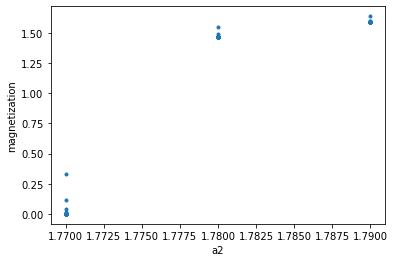

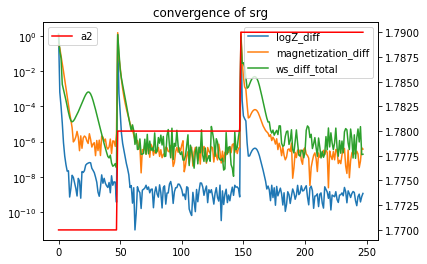

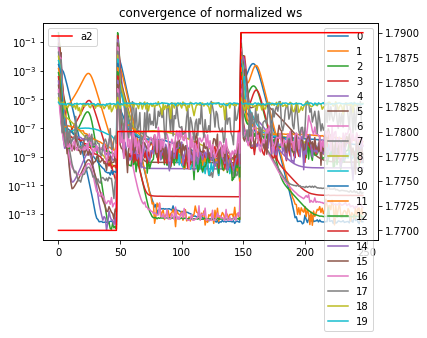

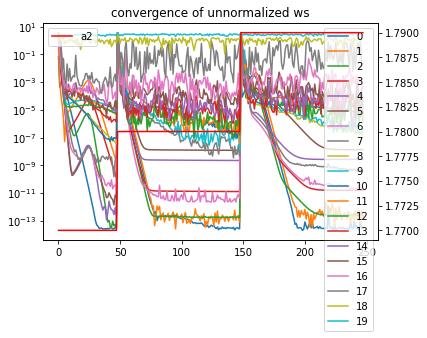

In [7]:

data=pd.read_csv(script_name+'.csv',converters={'ws_diff': eval_np_array_literal,'ws_diff_normalized': eval_np_array_literal})

plt.plot(data['a2'],data['magnetization'],'.')
plt.xlabel('a2')
plt.ylabel('magnetization')
plt.show()


plt.plot(data['logZ_diff'],label='logZ_diff')
plt.plot(data['magnetization_diff'],label='magnetization_diff')
plt.plot(data['ws_diff_total'],label='ws_diff_total')
plt.yscale('log')
plt.legend()
plt.twinx().plot(data['a2'],label='a2',color='red')
plt.legend()
plt.title('convergence of srg')
plt.show()

ws_diff=np.stack(data['ws_diff_normalized']).T
for i in range(ws_diff.shape[0]):
    plt.plot(ws_diff[i],label=i)
plt.yscale('log')
plt.legend()
plt.twinx().plot(data['a2'],label='a2',color='red')
plt.legend()
plt.title('convergence of normalized ws')
plt.show()


ws_diff=np.stack(data['ws_diff']).T
for i in range(ws_diff.shape[0]):
    plt.plot(ws_diff[i],label=i)
plt.yscale('log')
plt.legend()
plt.twinx().plot(data['a2'],label='a2',color='red')
plt.legend()
plt.title('convergence of unnormalized ws')
plt.show()

In [47]:
loss=np.array(data['ws_diff_total'])
    

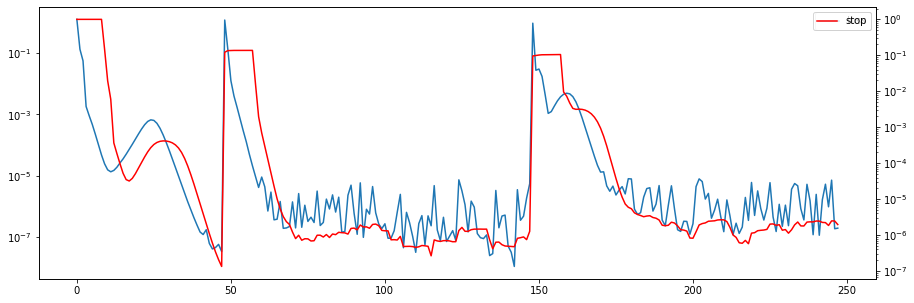

In [83]:
def smart_cutoff(loss):
    if len(loss)<10: return 1
    loss=np.array(loss)[-10:]
    aloss=np.average(np.abs(loss))
    dloss=np.average(np.abs(loss[1:]-loss[:-1]))
    adloss=np.abs(loss[1]-loss[-1])/len(loss)
    return aloss

stop=[smart_cutoff(loss[:i+1]) for i in range(len(loss))]
plt.figure(figsize=(15,5))
plt.plot(loss,label='loss')
plt.yscale('log')
plt.legend()
plt.twinx().plot(stop,label='stop',color='red')
plt.yscale('log')
plt.legend()
plt.show()

# AKLT 3D

In [97]:
class AKLT3D(HOTRG):
    default_params={'a1':np.sqrt(20/15),'a2':np.sqrt(20/6),'a3':np.sqrt(20/1)}
    def __init__(self,params,options):
        super(AKLT3D,self).__init__(params,options)
        self.create_isometries(start_dim=4,spacial_dim=3)
        self.TRG=self.HOTRG3D
        self.observable_checkerboard=True
        self.magnetization=0
        self.magnetization_diff=0
        
    def get_T0(self):
        projector=self.toT(get_CG_no_normalization(6))
        singlet=self.toT([[0,-1],[1,0]])
        ac0,ac1,ac2,ac3=self.toT(1),self.params['a1'],self.params['a2'],self.params['a3']
        deform=torch.stack([ac3,ac2,ac1,ac0,ac1,ac2,ac3])
        node=contract('aijklmn,io,kp,mq,a->aojplqn',projector,singlet,singlet,singlet,deform)
        return contract('aijklmn,aopqrst->iojpkqlrmsnt',node,node).reshape(4,4,4,4,4,4)#UDLRFB

    def get_SZT0(self):
        projector=self.toT(get_CG_no_normalization(6))
        singlet=self.toT([[0,-1],[1,0]])
        ac0,ac1,ac2,ac3=self.toT(1),self.params['a1'],self.params['a2'],self.params['a3']
        deform=torch.stack([ac3,ac2,ac1,ac0,ac1,ac2,ac3])
        node=contract('aijklmn,io,kp,mq,a->aojplqn',projector,singlet,singlet,singlet,deform)
        op=self.toT([3,2,1,0,-1,-2,-3])
        return contract('aijklmn,aopqrst,a->iojpkqlrmsnt',node,node,op).reshape(4,4,4,4,4,4)#UDLRFB
    
    def calc_magnetization(self):
        with torch.no_grad():
            new_magnetization=_toN(torch.abs(self.forward_with_observable(self.get_SZT0())))
            self.magnetization_diff=np.abs(self.magnetization-new_magnetization)
            self.magnetization=new_magnetization

# Determine Convergence

In [98]:
options={
    'dtype':torch.float64,
    'device':'cuda:0',
    'max_dim':9, # 12 for float32
    'nLayers':20,
    'use_checkpoint':True
}
print(options)

MAX_ITER=40
convergence_ws_threshold=1e-8

data=pd.DataFrame()
srg=AKLT3D(AKLT3D.default_params,options)

a3s=[2]
for a3 in a3s:
    params={'a1':0,'a2':0,'a3':a3}
    srg.set_params(params,options)
    
    pbar=tqdm(range(MAX_ITER))
    for _iter in pbar:
        
        srg.optimize(1)
        srg.calc_magnetization()
        
        pbar.set_postfix({'ΔlogZ':srg.logZ_diff,'Δm':srg.magnetization_diff,'Δw':srg.ws_diff_total})
        
        newRow={'a1':params['a1'],'a2':params['a2'],'iter':_iter+1,
                'logZ':srg.logZ,'magnetization':srg.magnetization,
                'logZ_diff':srg.logZ_diff,'magnetization_diff':srg.magnetization_diff,
                'ws_diff_total':srg.ws_diff_total,
                'ws_diff':srg.ws_diff
               }
        data=data.append(newRow,ignore_index=True)
        data.to_csv(script_name+'.csv')
        
        #if srg.magnetization_diff>1.1*average_dm:
            #break
            
    for k,v in newRow.items():
        print(k,':',v,end=' ')
    print()


{'dtype': torch.float64, 'device': 'cuda:0', 'max_dim': 9, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

/home/wenhan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

a1 : 0 a2 : 1.78 iter : 40 logZ : 1.1734446123336328 magnetization : 1.3584140353668688 logZ_diff : 1.1734446123336328 magnetization_diff : 6.024750008659652e-06 ws_diff_total : 4.472077295851635e-10 ws_diff : [1.36166734e-16 4.86803542e-15 5.12835487e-15 4.59008500e-14
 5.53832820e-14 1.24961487e-09 2.30286935e-09 1.50486920e-08
 3.32168118e-09 1.48885812e-08 2.02573355e-09 1.05850840e-08
 7.78013141e-10 2.37179373e-08 6.12404937e-09 3.91195655e-07
 2.89548700e-06 1.91120920e-05 1.13886055e-03 3.21170898e-03] 


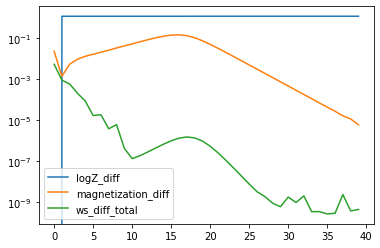

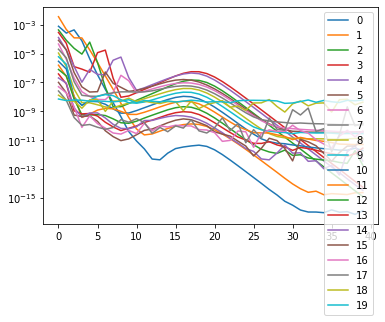

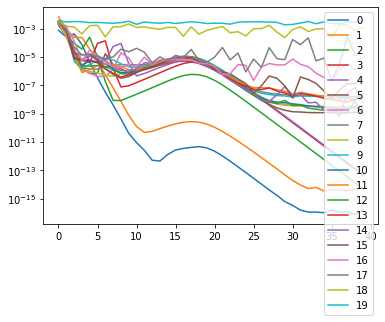

In [99]:

data=pd.read_csv(script_name+'.csv',converters={'ws_diff': str2array})


plt.plot(data['logZ_diff'],label='logZ_diff')
plt.plot(data['magnetization_diff'],label='magnetization_diff')
plt.plot(data['ws_diff_total'],label='ws_diff_total')
plt.yscale('log')
plt.legend()
plt.show()

ws_diff=np.stack(data['ws_diff']).T
for i in range(ws_diff.shape[0]):
    plt.plot(ws_diff[i]/2**i,label=i)
plt.yscale('log')
plt.legend()
plt.show()

ws_diff=np.stack(data['ws_diff']).T
for i in range(ws_diff.shape[0]):
    plt.plot(ws_diff[i],label=i)
plt.yscale('log')
plt.legend()
plt.show()